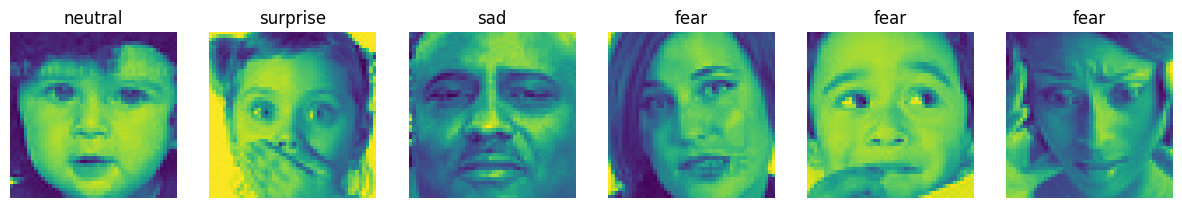

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

def visualize_raw_samples(directory, n=6):
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        label = random.choice(os.listdir(directory))
        image_file = random.choice(os.listdir(os.path.join(directory, label)))
        image_path = os.path.join(directory, label, image_file)
        image = Image.open(image_path)
        
        axs[i].imshow(image)
        axs[i].set_title(label)
        axs[i].axis('off')

directory_path = '/kaggle/input/fer2013/train/'
visualize_raw_samples(directory_path)


In [2]:
import os
from collections import Counter

def analyze_label_distribution(directory):
    labels = []
    for label in os.listdir(directory):
        images = os.listdir(os.path.join(directory, label))
        labels.extend([label] * len(images))
    
    label_counts = Counter(labels)
    return label_counts

directory_path = '/kaggle/input/fer2013/train/'
label_distribution = analyze_label_distribution(directory_path)
print(label_distribution)


Counter({'happy': 7215, 'neutral': 4965, 'sad': 4830, 'fear': 4097, 'angry': 3995, 'surprise': 3171, 'disgust': 436})


In [3]:
# from PIL import Image

# def find_corrupt_images(directory):
#     corrupt_files = []
#     for label in os.listdir(directory):
#         image_files = os.listdir(os.path.join(directory, label))
#         for image_file in image_files:
#             try:
#                 with Image.open(os.path.join(directory, label, image_file)) as img:
#                     img.verify()
#             except (IOError, SyntaxError) as e:
#                 corrupt_files.append(os.path.join(directory, label, image_file))
#     return corrupt_files

# directory_path = '/kaggle/input/fer2013/train/'
# corrupt_images = find_corrupt_images(directory_path)
# print(f"Found {len(corrupt_images)} corrupt images")


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

class FacialExpressionsDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []

        for label in os.listdir(directory):
            for image_file in glob.glob(os.path.join(directory, label, '*.jpg')):
                self.images.append(image_file)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        label_to_idx = {'happy': 0, 'sad': 1, 'angry': 2, 'disgust': 3, 'fear': 4, 'surprise': 5, 'neutral': 6}
        label_idx = label_to_idx[label]

        return image, label_idx

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = FacialExpressionsDataset(directory='/kaggle/input/fer2013/train/', transform=transform)
test_dataset = FacialExpressionsDataset(directory='/kaggle/input/fer2013/test/', transform=transform)


val_size = int(len(train_dataset) * 0.45)
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True)

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 16 00:12:24 2020

@author: NAT
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 7)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg: 
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [6]:
num_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DCRAN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
model = VGG('VGG19').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def validate_model(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            
            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
    avg_loss = running_loss / len(data_loader)
    avg_acc = correct_predictions / total_predictions * 100
    return avg_loss, avg_acc

def train_and_validate_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_accuracy = 0.0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions / total_predictions * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        val_loss, val_acc = validate_model(model, criterion, val_loader)
        test_loss, test_acc = validate_model(model, criterion, test_loader)

        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%'
              f'Test loss: {test_loss:4f}, Test acc: {test_acc:.2f}%')

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    print('Finished Training')
    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=40)


Epoch 1/40, Train Loss: 1.8637, Train Acc: 24.19%, Val Loss: 1.7816, Val Acc: 27.05%Test loss: 1.791762, Test acc: 26.24%
Epoch 2/40, Train Loss: 1.7176, Train Acc: 29.36%, Val Loss: 1.7765, Val Acc: 25.65%Test loss: 1.771737, Test acc: 26.60%
Epoch 3/40, Train Loss: 1.5642, Train Acc: 38.08%, Val Loss: 1.3792, Val Acc: 46.72%Test loss: 1.391511, Test acc: 46.09%
Epoch 4/40, Train Loss: 1.3597, Train Acc: 47.70%, Val Loss: 1.2403, Val Acc: 52.01%Test loss: 1.269924, Test acc: 50.01%
Epoch 5/40, Train Loss: 1.2633, Train Acc: 51.83%, Val Loss: 1.3428, Val Acc: 48.81%Test loss: 1.372545, Test acc: 48.58%
Epoch 6/40, Train Loss: 1.1996, Train Acc: 54.26%, Val Loss: 1.2029, Val Acc: 54.42%Test loss: 1.280756, Test acc: 51.93%
Epoch 7/40, Train Loss: 1.1453, Train Acc: 56.35%, Val Loss: 1.1216, Val Acc: 57.17%Test loss: 1.236021, Test acc: 53.96%
Epoch 8/40, Train Loss: 1.0963, Train Acc: 58.44%, Val Loss: 1.0175, Val Acc: 61.79%Test loss: 1.157858, Test acc: 56.67%
Epoch 9/40, Train Loss: 